In [27]:
import os
os.getcwd()

'/Users/saman/Downloads/portfolio-diversification-project/notebooks'

# Portfolio Diversification and Risk Analysis

# 1. Introduction

This project examines the diversification benefits and risk–return trade-offs of a multi-asset portfolio using daily data from 2016 to 2025. The portfolio consists of five asset classes, represented by widely used financial proxies:

- **SPY** – US Equities (S&P 500)
- **VEA** – International Equities (Developed Markets ex-US)
- **IEF** – US Treasury Bonds (Intermediate Term)
- **GLD** – Gold (Commodity / Defensive Asset)
- **BTC** – Bitcoin (High-volatility Alternative Asset)


# 2. Data Collection & Cleaning

This section describes the asset universe, data sources, and preprocessing steps. Daily adjusted price data are collected for multiple asset classes and aligned to ensure consistency across trading days before computing returns.

In [28]:
# Core data manipulation libraries
import pandas as pd
import numpy as np

# Financial data source
import yfinance as yf

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set a consistent plotting style
plt.style.use("seaborn-v0_8")

In [29]:
# Define the list of asset tickers used in the analysis
tickers = ["SPY", "VEA", "IEF", "GLD", "BTC-USD"]

# Define the time window for the analysis
start_date = "2016-01-01"
end_date = "2026-01-01"

# Download historical price data from Yahoo Finance
# auto_adjust=True accounts for dividends and splits
raw = yf.download(
    tickers,
    start=start_date,
    end=end_date,
    auto_adjust=True,
    progress=False,
    threads=False
)

# Extract adjusted closing prices
prices = raw.xs("Close", axis=1, level=0).copy()

# Sort data by date
prices = prices.sort_index()

prices.tail()

Ticker,BTC-USD,GLD,IEF,SPY,VEA
Date,,,,,
2025-12-27,87802.156250,NaN,NaN,NaN,NaN
2025-12-28,87835.835938,NaN,NaN,NaN,NaN
2025-12-29,87138.140625,398.600006,96.265923,687.849976,62.720001
2025-12-30,88430.132812,398.890015,96.166245,687.010010,62.790001
2025-12-31,87508.828125,396.309998,95.847290,681.919983,62.470001


In [30]:
# Rename Bitcoin ticker for cleaner column naming
prices = prices.rename(columns={"BTC-USD": "BTC"})

# Inspect final column names
prices.columns

Index(['BTC', 'GLD', 'IEF', 'SPY', 'VEA'], dtype='str', name='Ticker')

In [31]:
# Check for missing values across assets
# Missing values are expected due to different trading calendars
prices.isna().sum().sort_values(ascending=False)

Ticker
GLD    1139
IEF    1139
SPY    1139
VEA    1139
BTC       0
dtype: int64

In [32]:
# Define assets that follow traditional market trading days
traditional_assets = ["SPY", "VEA", "IEF", "GLD"]

# Keep only dates when all traditional assets have data
prices_aligned = prices.dropna(subset=traditional_assets).copy()

# Save aligned price data
prices_aligned.to_csv("../data/prices_aligned.csv")

# Final missing value check
prices_aligned.isna().sum()

Ticker
BTC    0
GLD    0
IEF    0
SPY    0
VEA    0
dtype: int64

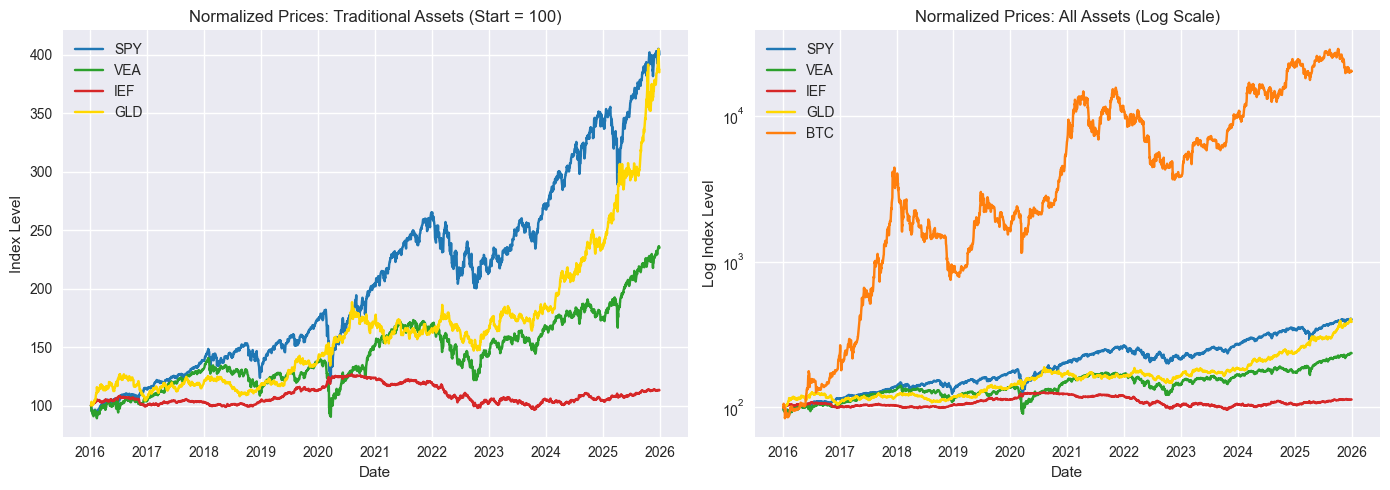

In [33]:
# Create normalized price series
normalized_prices = prices_aligned / prices_aligned.iloc[0] * 100

# Define asset groups and plotting order
traditional_assets = ["SPY", "VEA", "IEF", "GLD"]
all_assets = ["SPY", "VEA", "IEF", "GLD", "BTC"]

# Define a fixed color map for consistency across plots
color_map = {
    "SPY": "#1f77b4",   # blue
    "VEA": "#2ca02c",   # green
    "IEF": "#d62728",   # red
    "GLD": "#FFD700",   # gold
    "BTC": "#ff7f0e"    # orange
}

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Left plot: traditional assets (linear scale)
for asset in traditional_assets:
    axes[0].plot(
        normalized_prices.index,
        normalized_prices[asset],
        label=asset,
        color=color_map[asset]
    )

axes[0].set_title("Normalized Prices: Traditional Assets (Start = 100)")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Index Level")
axes[0].legend()

# --- Right plot: all assets (log scale)
for asset in all_assets:
    axes[1].plot(
        normalized_prices.index,
        normalized_prices[asset],
        label=asset,
        color=color_map[asset]
    )

axes[1].set_yscale("log")
axes[1].set_title("Normalized Prices: All Assets (Log Scale)")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Log Index Level")
axes[1].legend()

plt.tight_layout()
plt.show()

The normalized price series provide a visual sanity check of the underlying data. The observed dynamics align with economic intuition: equities exhibit higher growth and volatility relative to bonds, which display more stable behavior over time. Gold shows sustained growth with volatility characteristics that differ from both equities and bonds. Bitcoin exhibits substantially different growth dynamics and volatility compared with traditional assets.

# 3. Risk and Diversification Analysis

This section analyzes the risk characteristics of individual assets and examines diversification properties through volatility estimates and correlation analysis. These metrics form the foundation of modern portfolio theory.

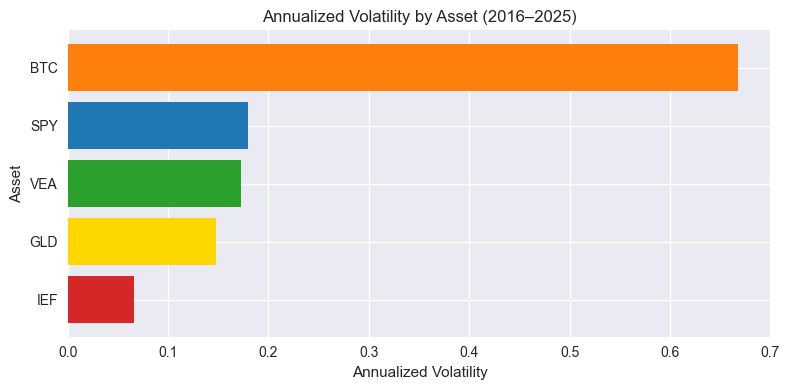

In [34]:
# Compute daily percentage returns for all assets
returns = prices_aligned.pct_change().dropna()

# Save returns data
returns.to_csv("../data/returns.csv")

# Compute annualized volatility from daily returns
# 252 trading days is the standard convention
annual_volatility = returns.std() * np.sqrt(252)

# Sort volatility from lowest to highest for clearer comparison
vol_sorted = annual_volatility.sort_values()

# Visualize
plt.figure(figsize=(8, 4))
plt.barh(
    vol_sorted.index,
    vol_sorted.values,
    color=[color_map[a] for a in vol_sorted.index]
)

plt.title("Annualized Volatility by Asset (2016–2025)")
plt.xlabel("Annualized Volatility")
plt.ylabel("Asset")
plt.tight_layout()
plt.show()

In [35]:
# Compute correlation matrix of daily returns
correlation_matrix = returns.corr()

correlation_matrix

Ticker,BTC,GLD,IEF,SPY,VEA
Ticker,,,,,
BTC,1.000000,0.096525,-0.006110,0.239824,0.233349
GLD,0.096525,1.000000,0.357623,0.051612,0.166244
IEF,-0.006110,0.357623,1.000000,-0.144547,-0.094403
SPY,0.239824,0.051612,-0.144547,1.000000,0.858135
VEA,0.233349,0.166244,-0.094403,0.858135,1.000000


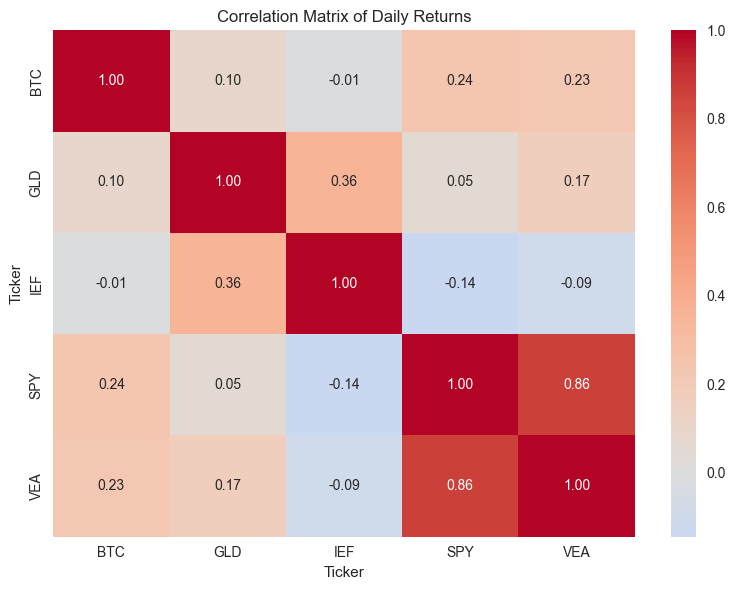

In [36]:
# Visualize correlations to highlight diversification patterns
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0
)

plt.title("Correlation Matrix of Daily Returns")
plt.tight_layout()
plt.show()

## Correlation and Diversification Insights

The correlation matrix shows that equities and bonds exhibit low to negative correlation, supporting the traditional diversification role of fixed income assets. Gold displays low correlation with both equities and bonds, reinforcing its role as a defensive asset. Bitcoin exhibits weak correlation with traditional assets, indicating potential diversification benefits, albeit with substantially higher volatility.

# 4. Portfolio Construction

This section compares a simple equal-weight portfolio with optimized portfolios derived from mean–variance optimization. Minimum volatility and maximum Sharpe ratio portfolios are constructed to evaluate potential improvements in risk-adjusted performance.

In [37]:
# Define a simple equal-weight portfolio as a baseline
assets = returns.columns.tolist()
n_assets = len(assets)
w_equal = np.array([1 / n_assets] * n_assets)

w_equal

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [38]:
# Helper function to compute annualized return, volatility, and Sharpe ratio
def portfolio_performance(returns_df, weights, rf=0.0):
    """
    returns_df: daily returns DataFrame
    weights: array-like weights (sum to 1)
    rf: annual risk-free rate (set to 0 for simplicity here)
    """
    mean_daily = returns_df.mean()
    cov_daily = returns_df.cov()

    annual_return = np.dot(mean_daily, weights) * 252
    annual_vol = np.sqrt(np.dot(weights.T, np.dot(cov_daily * 252, weights)))
    sharpe = (annual_return - rf) / annual_vol

    return annual_return, annual_vol, sharpe

In [39]:
# Compute baseline equal-weight portfolio metrics
eq_ret, eq_vol, eq_sharpe = portfolio_performance(returns, w_equal)

pd.Series(
    {"Annual Return": eq_ret, "Annual Volatility": eq_vol, "Sharpe (rf=0)": eq_sharpe},
    name="Equal-Weight"
)

Annual Return        0.234662
Annual Volatility    0.170943
Sharpe (rf=0)        1.372747
Name: Equal-Weight, dtype: float64

In [40]:
# Estimate expected returns and covariance matrix for optimization
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier

mu = mean_historical_return(prices_aligned, frequency=252)  # annualized expected returns
S = CovarianceShrinkage(prices_aligned).ledoit_wolf()       # robust covariance estimate

In [41]:
# Construct the minimum volatility portfolio
ef_minvol = EfficientFrontier(mu, S)
ef_minvol.min_volatility()

# Clean weights for readability
w_minvol_clean = ef_minvol.clean_weights()
w_minvol_clean

OrderedDict([('BTC', 0.0),
             ('GLD', 0.03107),
             ('IEF', 0.80238),
             ('SPY', 0.12198),
             ('VEA', 0.04458)])

In [42]:
# Construct the maximum Sharpe ratio portfolio (rf=0 for simplicity)
ef_maxsharpe = EfficientFrontier(mu, S)
ef_maxsharpe.max_sharpe(risk_free_rate=0.0)

# Clean weights for readability
w_maxsharpe_clean = ef_maxsharpe.clean_weights()
w_maxsharpe_clean

OrderedDict([('BTC', 0.12285),
             ('GLD', 0.56258),
             ('IEF', 0.0),
             ('SPY', 0.31458),
             ('VEA', 0.0)])

In [43]:
# Get the performance of optimized portfolios
minvol_perf = ef_minvol.portfolio_performance(verbose=False)
maxsharpe_perf = ef_maxsharpe.portfolio_performance(verbose=False)

# Compare all portfolio structures
comparison = pd.DataFrame({
    "Annual Return": [eq_ret, minvol_perf[0], maxsharpe_perf[0]],
    "Annual Volatility": [eq_vol, minvol_perf[1], maxsharpe_perf[1]],
    "Sharpe (rf=0)": [eq_sharpe, minvol_perf[2], maxsharpe_perf[2]],
}, index=["Equal-Weight", "Min Volatility", "Max Sharpe"])

comparison

,Annual Return,Annual Volatility,Sharpe (rf=0)
Equal-Weight,0.234662,0.170943,1.372747
Min Volatility,0.036548,0.062068,0.588844
Max Sharpe,0.214750,0.145055,1.480469


In [44]:
# Display portfolio weights for interpretability
weights_df = pd.DataFrame({
    "Equal-Weight": pd.Series(w_equal, index=assets),
    "Min Volatility": pd.Series(w_minvol_clean),
    "Max Sharpe": pd.Series(w_maxsharpe_clean)
})

weights_df

,Equal-Weight,Min Volatility,Max Sharpe
BTC,0.2,0.00000,0.12285
GLD,0.2,0.03107,0.56258
IEF,0.2,0.80238,0.00000
SPY,0.2,0.12198,0.31458
VEA,0.2,0.04458,0.00000


## Portfolio Construction Results

We compare a simple equal-weight portfolio with optimized portfolios (minimum volatility and maximum Sharpe). Optimized allocations demonstrate how portfolio weights shift across asset classes to reduce risk or improve risk-adjusted returns. In later sections, we will test robustness by re-estimating portfolios over different subperiods to evaluate the stability of these weights.

# 5. Robustness Checks

To assess the stability of optimized portfolios, this section re-estimates portfolio weights across different subperiods. This analysis highlights the sensitivity of mean–variance optimization to the estimation window and input assumptions.

In [45]:
# Define two subperiods to test robustness
subperiods = {
    "2016–2020": ("2016-01-01", "2020-12-31"),
    "2021–2025": ("2021-01-01", "2025-12-31")
}

In [46]:
# Store optimized weights for each subperiod
subperiod_weights = {}

for label, (start, end) in subperiods.items():
    # Slice price data
    prices_sub = prices_aligned.loc[start:end]

    # Estimate expected returns and covariance
    mu_sub = mean_historical_return(prices_sub, frequency=252)
    S_sub = CovarianceShrinkage(prices_sub).ledoit_wolf()

    # Max Sharpe portfolio for each subperiod
    ef = EfficientFrontier(mu_sub, S_sub)
    ef.max_sharpe(risk_free_rate=0.0)

    subperiod_weights[label] = ef.clean_weights()

In [47]:
# Convert subperiod optimized weights to DataFrame
weights_sub_df = pd.DataFrame(subperiod_weights)
weights_sub_df["2016–2025"] = weights_df["Max Sharpe"]

weights_sub_df

,2016–2020,2021–2025,2016–2025
BTC,0.09916,0.00922,0.12285
GLD,0.11222,0.59457,0.56258
IEF,0.58839,0.00000,0.00000
SPY,0.20023,0.39621,0.31458
VEA,0.00000,0.00000,0.00000


## Robustness and Subperiod Analysis

The subperiod analysis highlights that optimized portfolio weights are sensitive to the chosen estimation window. Asset allocations, particularly for higher-volatility assets such as Bitcoin, vary substantially across subperiods. This illustrates the presence of estimation risk in mean–variance optimization and underscores the importance of robustness checks when applying optimized portfolios in practice.

# 6. Conclusion

This project examined the diversification benefits and risk–return trade-offs of a multi-asset portfolio using daily data from 2016 to 2025. By combining equities, fixed income, gold, and Bitcoin, the analysis illustrated how assets with differing risk profiles and correlation structures contribute to portfolio diversification.

The results show that traditional diversification between equities and bonds remains effective, while gold provides additional defensive characteristics through its low correlation with equities. Bitcoin, despite its extreme volatility, exhibits weak correlation with traditional assets and can influence optimized portfolios when return estimates are favorable. However, the portfolio optimization results also highlight the sensitivity of mean–variance frameworks to estimation error, particularly when high-volatility assets are included.

A robustness analysis across subperiods demonstrates that optimal portfolio weights are not stable over time, underscoring the importance of cautious interpretation and the need for robustness checks in practical portfolio construction. Overall, the findings emphasize that while quantitative optimization can improve risk-adjusted performance, sound financial judgment and awareness of model limitations are essential when applying these techniques in real-world investment decisions.